In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sklearn

import torch
import torchvision as vision
from torchvision.utils import make_grid

from hypernevus.models import Autoencoder

In [2]:
output_dir = Path("../output/2020-06-25-1333/")
assert output_dir.exists()

In [3]:
ckpt_file = output_dir / "epoch-49.ckpt"
assert ckpt_file.exists()

In [4]:
ckpt = torch.load(ckpt_file)

In [5]:
num_bands = 115
autoencoder = Autoencoder(num_bands)
autoencoder.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [6]:
autoencoder.eval()
autoencoder.requires_grad_(False)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(115, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Conv2d(64, 115, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Sig

In [7]:
data_dir = Path("../data/patches/64")
assert data_dir.exists()

In [8]:
max_bands = 120
band_slice = slice(0, 115)
num_bands = len(range(*band_slice.indices(max_bands)))
print(num_bands)

def loader(file_path):
        hsi = np.load(file_path)
        hsi = hsi[..., band_slice]
        hsi = np.transpose(hsi, axes=[2, 0, 1])
        hsi = np.clip(hsi, 0, 1)
        return hsi

np.random.seed(42)
torch.manual_seed(42)

dataset = vision.datasets.DatasetFolder(str(data_dir), loader, extensions=".npy")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

115


In [9]:
from math import ceil
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure


def make_grid(tensor, ncols=8, vmin=0, vmax=1, cmap="viridis"):
    fig = Figure(figsize=(8, 8), dpi=600)
    canvas = FigureCanvasAgg(fig)

    nrows = ceil(tensor.shape[0] / ncols)

    for image_num, image in enumerate(tensor, start=1):
        ax = fig.add_subplot(nrows, ncols, image_num)
        ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.axis("off")

    fig.tight_layout()
    canvas.draw()
    buf = canvas.buffer_rgba()    
    image_grid = np.asarray(buf)
    
    return image_grid

In [10]:
def show_image_grid(image, axes, band=50, vmin=0, vmax=1, cmap="viridis"):
    temp_image = image.detach().cpu()
    temp_image = temp_image[:, band]
    # temp_image = torch.unsqueeze(temp_image, dim=1)
    # temp_image = temp_image.permute(0, 2, 3, 1)
    
    image_grid = make_grid(temp_image, vmin=vmin, vmax=vmax, cmap=cmap)
    # image_grid = np.transpose(image_grid, axes=[1, 2, 0])
    # image_grid = image_grid[..., 0]    
    axes.imshow(image_grid)
    axes.axis("off")

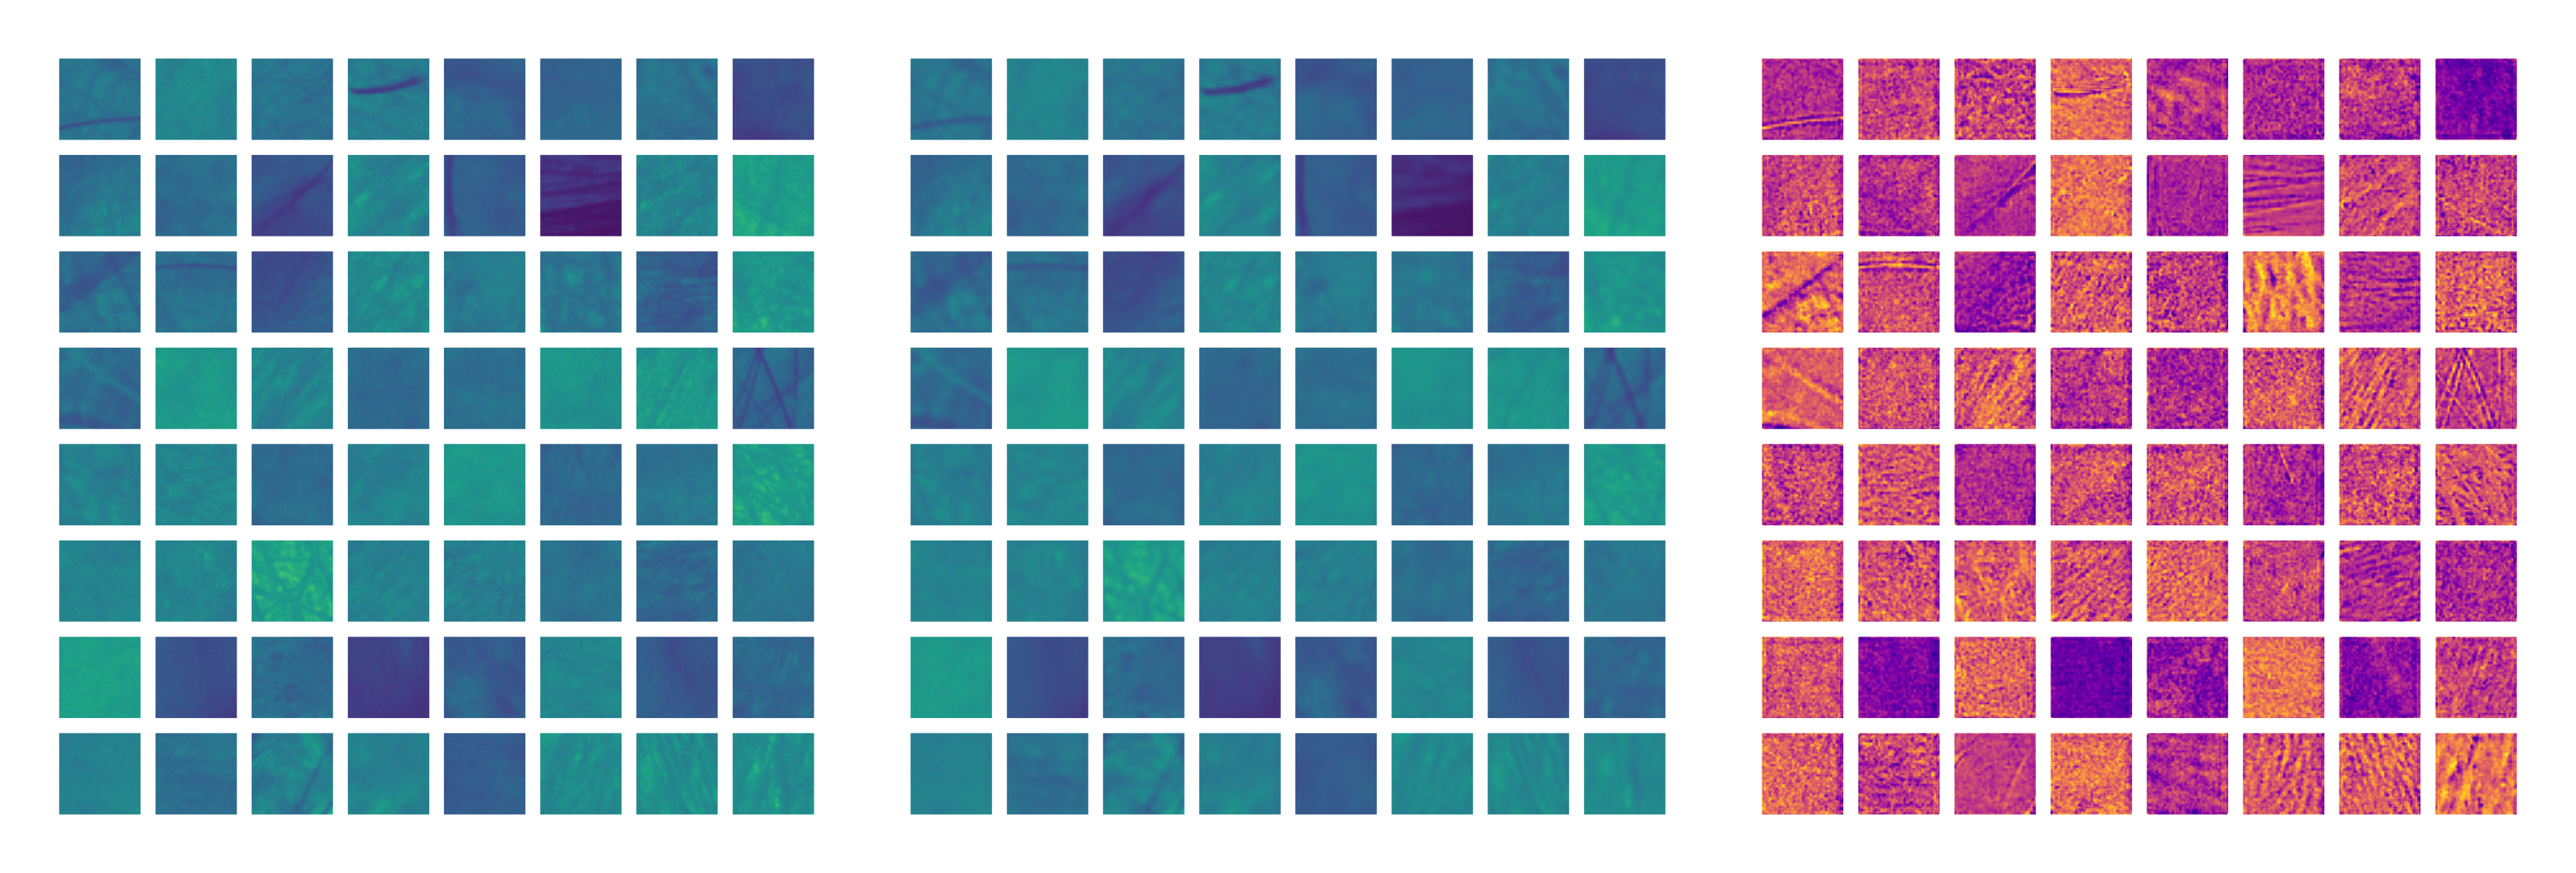

In [11]:
for batch_idx, (image, _) in enumerate(dataloader):
    if batch_idx == 1:
        break

    reconstructed_image = autoencoder(image)
    difference_image = reconstructed_image - image
            
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, dpi=600)
    show_image_grid(image, ax1)
    show_image_grid(reconstructed_image, ax2)
    show_image_grid(difference_image, ax3, vmin=None, vmax=None, cmap="plasma")
    fig.tight_layout()
    fig.savefig(str(output_dir / f"viz-{ckpt_file.stem}.pdf" ))

In [14]:
codes = []
code_labels = []
for idx, (images, labels) in enumerate(dataloader):
    if idx % 10 == 0:
        print(idx)
    x = autoencoder.encoder(images)
    x = x.view(-1, 32 * 16 * 16).detach().numpy()
    codes.append(x)
    code_labels.append(labels.detach().numpy())

codes = np.concatenate(codes, axis=0)
code_labels = np.concatenate(code_labels, axis=0)
print(codes.shape, code_labels.shape)

115


ValueError: need at least one array to concatenate

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
pca = PCA(n_components=50)
x_pca = pca.fit_transform(codes)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [15]:
print(np.sum(pca.explained_variance_ratio_))

NameError: name 'pca' is not defined

In [41]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, verbose=1)
# x_tsne = tsne.fit_transform(codes)
x_tsne = tsne.fit_transform(x_pca)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 22272 samples in 0.180s...
[t-SNE] Computed neighbors for 22272 samples in 16.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22272
[t-SNE] Computed conditional probabilities for sample 2000 / 22272
[t-SNE] Computed conditional probabilities for sample 3000 / 22272
[t-SNE] Computed conditional probabilities for sample 4000 / 22272
[t-SNE] Computed conditional probabilities for sample 5000 / 22272
[t-SNE] Computed conditional probabilities for sample 6000 / 22272
[t-SNE] Computed conditional probabilities for sample 7000 / 22272
[t-SNE] Computed conditional probabilities for sample 8000 / 22272
[t-SNE] Computed conditional probabilities for sample 9000 / 22272
[t-SNE] Computed conditional probabilities for sample 10000 / 22272
[t-SNE] Computed conditional probabilities for sample 11000 / 22272
[t-SNE] Computed conditional probabilities for sample 12000 / 22272
[t-SNE] Computed conditional probabilities for s

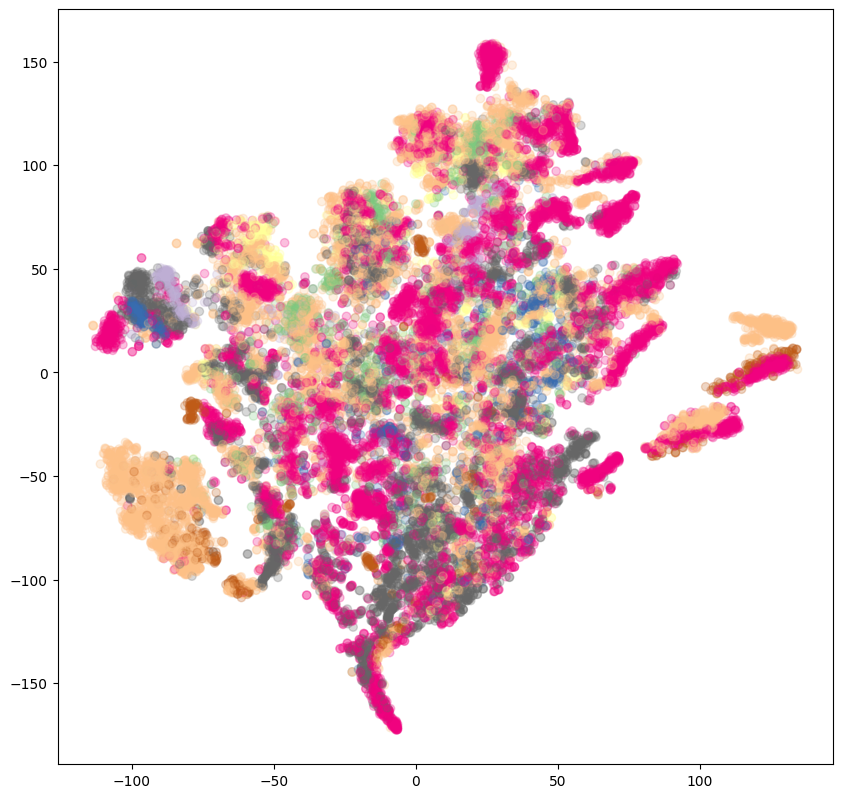

In [42]:
plt.figure(figsize=(10, 10), dpi=100)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=code_labels, cmap="Accent", alpha=0.25);

In [26]:
from mpl_toolkits.mplot3d import Axes3D

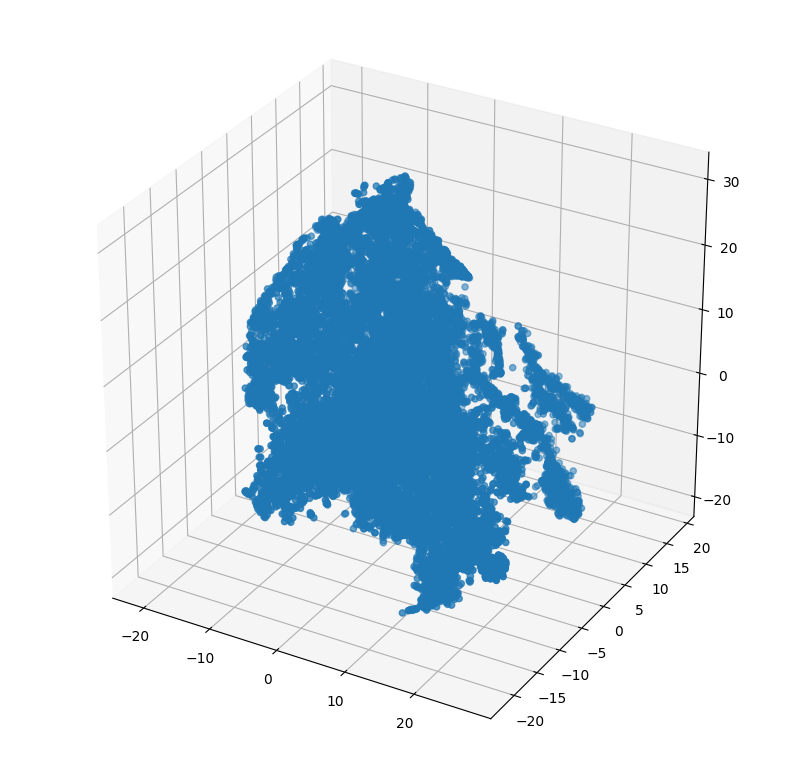

In [35]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, projection="3d")

x, y, z = x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2]
ax.scatter(x, y, z);

In [67]:
np.random.seed(42)
torch.manual_seed(42)

for idx, (images, labels) in enumerate(dataloader):
    print(code_labels[:64])
    print(labels.numpy())
    break

[2 5 5 2 8 3 8 2 0 2 8 0 6 5 7 2 8 2 5 5 0 5 2 2 8 2 4 7 5 2 5 5 5 5 2 4 0
 5 2 2 5 5 2 5 5 7 2 5 5 5 0 7 7 1 6 2 2 5 6 0 8 5 5 2]
[2 5 5 2 8 3 8 2 0 2 8 0 6 5 7 2 8 2 5 5 0 5 2 2 8 2 4 7 5 2 5 5 5 5 2 4 0
 5 2 2 5 5 2 5 5 7 2 5 5 5 0 7 7 1 6 2 2 5 6 0 8 5 5 2]
